In [1]:
from keras_vggface.vggface import VGGFace
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras_vggface.utils import preprocess_input
from keras.models import Model
import numpy as np
from keras import Sequential
from keras import Input
from keras.layers import Dense,Flatten,GlobalAveragePooling2D,GlobalMaxPooling2D,MaxPooling2D
from keras import optimizers
import tensorflow as tf
from keras import backend as K

from keras.utils.np_utils import to_categorical


Using TensorFlow backend.


In [2]:
def load_file(examples_list_file):
    lines = np.genfromtxt(examples_list_file, delimiter="", dtype=[('col1', 'S120'), ('col2', 'i8')])
    #f=open(train_file)
    #lines=f.readlines()
    examples = []
    labels = []
    for example, label in lines:
        examples.append(example)
        labels.append(label)
    return np.asarray(examples), np.asarray(labels)

def imgs_input_fn(filenames, labels=None, perform_shuffle=False, repeat_count=1, batch_size=1):
    def _parse_function(filename, label):
        image_string = tf.read_file(filename)
        image = tf.image.decode_image(image_string, channels=3)
        image.set_shape([None, None, None])
        image = tf.image.resize_images(image, [150, 150])
        image.set_shape([150, 150, 3])
        #image = tf.reverse(image, axis=[2]) # 'RGB'->'BGR'
        #d = dict(zip(["input_1"], [image])), label
        return image,label
    if labels is None:
        labels = [0]*len(filenames)
    labels=np.array(labels)
    # Expand the shape of "labels" if necessory
    if len(labels.shape) == 1:
        labels = np.expand_dims(labels, axis=1)
    filenames = tf.constant(filenames)
    labels = tf.constant(labels)
    labels = tf.cast(labels, tf.float32)
    dataset = tf.data.Dataset.from_tensor_slices((filenames, labels))
    dataset = dataset.map(_parse_function)
    if perform_shuffle:
        # Randomizes input using a window of 256 elements (read into memory)
        dataset = dataset.shuffle(buffer_size=256)
    dataset = dataset.repeat(repeat_count)  # Repeats dataset this # times
    dataset = dataset.batch(batch_size)  # Batch size to use
    iterator = dataset.make_one_shot_iterator()
    batch_features, batch_labels = iterator.get_next()
    return batch_features, batch_labels

def setup_to_finetune(model):
   """Freeze the bottom NB_IV3_LAYERS and retrain the remaining top 
      layers.
   note: NB_IV3_LAYERS corresponds to the top 2 inception blocks in 
         the inceptionv3 architecture
   Args:
     model: keras model
   """
   for layer in model.layers[:"pool5"]:
      layer.trainable = False
   for layer in model.layers["pool5":]:
      layer.trainable = True

In [3]:
base_dir = 'k-fold'
train_files=base_dir+"/face_crop_path/train01.txt"
valid_files=base_dir+"/face_crop_path/valid01.txt"

examples_train,labels_train=load_file(train_files)
examples_valid,labels_valid=load_file(valid_files)

In [4]:
img_train=np.empty((len(examples_train),224,224,3),dtype="float32")
#print (len(examples_train))
for i in range(5):
    images = image.load_img(examples_train[i], target_size=(224, 224,3))  
    x = image.img_to_array(images)
    #x = np.expand_dims(x, axis=0) 
    img_train[i,:,:,:] = x
    
img_valid=np.empty((len(examples_valid),224,224,3),dtype="float32")
#print (len(examples_valid))
for i in range(5):
    images = image.load_img(examples_train[i], target_size=(224, 224,3))  
    x = image.img_to_array(images)
    #x = np.expand_dims(x, axis=0) 
    img_valid[i,:,:,:] = x
    
#print(labels_train)
categorical_labels = to_categorical(labels_train, num_classes=6)[:,1:6]
valid_labels=to_categorical(labels_valid,num_classes=6)[:,1:6]

In [5]:
conv_base = VGGFace(model = 'vgg16', weights = 'vggface',input_shape=None,include_top=False)
conv_base.trainable = False
#print(conv_base.summary())
x_input = Input(shape=(224,224,3))
x =  (conv_base)(x_input)
x = GlobalAveragePooling2D()(x)
x = Dense(512,activation= 'relu')(x)
predictions = Dense(5,activation='softmax')(x)
#setup_to_finetune(model)
model = Model(inputs=x_input,outputs=predictions)
#model.summary()
opt = optimizers.Adam(lr=0.0001)

model.compile(optimizer=opt,loss='categorical_crossentropy',metrics=['accuracy'])

In [9]:
history=model.fit(img_train,categorical_labels,batch_size=None,epochs=15,
          verbose=1, callbacks=None, validation_split=0.0,
          validation_data=(img_valid,valid_labels), shuffle=True, 
          class_weight=None, sample_weight=None, 
          initial_epoch=10, steps_per_epoch=None, 
          validation_steps=None)


Train on 16226 samples, validate on 497 samples
Epoch 11/15
16226/16226 [==============================] - 79s 5ms/step - loss: 1.5677 - acc: 0.3755 - val_loss: 1.6329 - val_acc: 0.5614
Epoch 12/15
16226/16226 [==============================] - 78s 5ms/step - loss: 1.5462 - acc: 0.3755 - val_loss: 1.5728 - val_acc: 0.5614
Epoch 13/15
16226/16226 [==============================] - 77s 5ms/step - loss: 1.5258 - acc: 0.3755 - val_loss: 1.5126 - val_acc: 0.5614
Epoch 14/15
16226/16226 [==============================] - 79s 5ms/step - loss: 1.5099 - acc: 0.3755 - val_loss: 1.4606 - val_acc: 0.5614
Epoch 15/15
16226/16226 [==============================] - 78s 5ms/step - loss: 1.4997 - acc: 0.3755 - val_loss: 1.4205 - val_acc: 0.5614


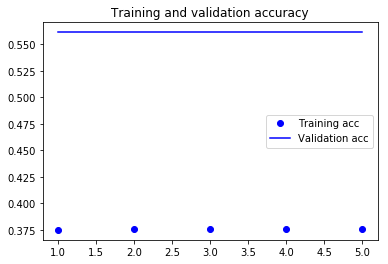

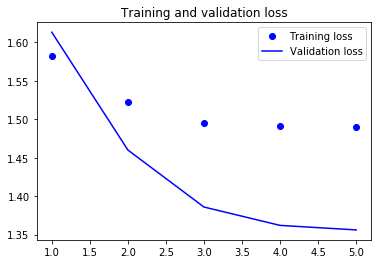

In [11]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()